In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from sklearn.utils import shuffle

In [ ]:
FOLDER = '/content/drive/MyDrive/hackaton/Development'

In [ ]:
IMG_SIZE = (256, 256)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!rm -rf 'Prepared_dataset'
!unzip -q {FOLDER + "/Dataset/prepared_skoltech_full.zip"}

In [ ]:
x_folder_path = "/content/Prepared_dataset/x"
y_folder_path = "/content/Prepared_dataset/y"

In [ ]:
n_start, n_end = 6000, 9000


x_array = np.array([np.load(f"{x_folder_path}/{i}") for i in sorted(os.listdir(x_folder_path)[n_start: n_end])]).astype(np.uint8)
y_array = np.array([np.load(f"{y_folder_path}/{i}") for i in sorted(os.listdir(y_folder_path)[n_start: n_end])]).astype(np.uint8)

In [ ]:
x_array, y_array = shuffle(x_array, y_array)

In [ ]:
x_train = x_array[:-100]
y_train = y_array[:-100]

x_test = x_array[-100:]
y_test = y_array[-100:]

In [ ]:
print("x:", x_train.shape)
print("y:", y_train.shape)
print()
print("x:", x_test.shape)
print("y:", y_test.shape)

x: (2900, 256, 256, 3)
y: (2900, 256, 256, 2)

x: (100, 256, 256, 3)
y: (100, 256, 256, 2)


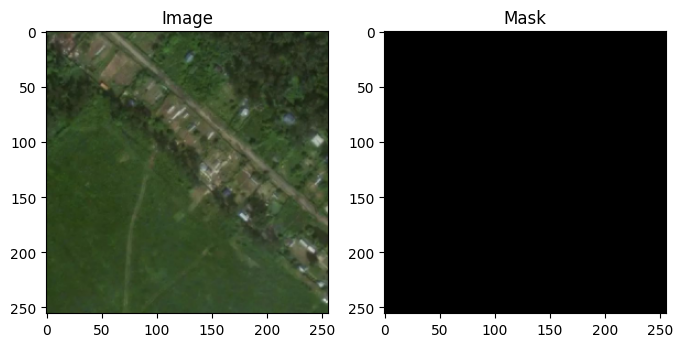

In [ ]:
i = 152
image, mask = Image.fromarray(x_train[i]), y_train[i][:, :, 0]

ig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(image)
axs[0].set_title('Image')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask')
plt.show()

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from keras import backend as K

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def build_model(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    concat5 = concatenate([conv3, up5], axis=-1)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    concat6 = concatenate([conv2, up6], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    concat7 = concatenate([conv1, up7], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat7)

    output = Conv2D(2, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_m])

    return model

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Reshape

def build_pspnet_model(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)

    # Pyramid Pooling Module
    pyramid_pooling = build_pyramid_pooling(conv4, [1, 2, 3, 6])

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(pyramid_pooling)
    concat5 = concatenate([conv3, up5], axis=-1)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    concat6 = concatenate([conv2, up6], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    concat7 = concatenate([conv1, up7], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat7)

    output = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def build_pyramid_pooling(input_layer, bin_sizes):
    concat_list = []

    for bin_size in bin_sizes:
        x = GlobalAveragePooling2D()(input_layer)
        x = Reshape((1, 1, x.shape[-1]))(x)
        x = Conv2D(256, (1, 1), activation='relu')(x)
        x = UpSampling2D(size=(input_layer.shape[1] // bin_size, input_layer.shape[2] // bin_size))(x)
        concat_list.append(x)

    return concatenate(concat_list, axis=-1)

# Build the model
pspnet_model = build_pspnet_model(input_shape=(256, 256, 3))
pspnet_model.summary()


In [ ]:
model = build_pspnet_model(x_array[0].shape)

TypeError: ignored

In [ ]:
model.load_weights(f"{FOLDER}/Weights/skoltech_unet_f1_9492.h5")

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("weights.h5", save_best_only=True)]

history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    callbacks=[callbacks]
)

Epoch 1/10
145/145 [==============================] - 53s 305ms/step - loss: 0.1387 - f1_m: 0.9456 - val_loss: 0.1369 - val_f1_m: 0.9444
Epoch 2/10
145/145 [==============================] - 46s 317ms/step - loss: 0.1329 - f1_m: 0.9479 - val_loss: 0.1396 - val_f1_m: 0.9434
Epoch 3/10
145/145 [==============================] - 42s 288ms/step - loss: 0.1347 - f1_m: 0.9475 - val_loss: 0.1383 - val_f1_m: 0.9453
Epoch 4/10
145/145 [==============================] - 38s 264ms/step - loss: 0.1238 - f1_m: 0.9513 - val_loss: 0.1367 - val_f1_m: 0.9452
Epoch 5/10
145/145 [==============================] - 46s 318ms/step - loss: 0.1172 - f1_m: 0.9536 - val_loss: 0.1563 - val_f1_m: 0.9329
Epoch 6/10
145/145 [==============================] - 44s 304ms/step - loss: 0.1144 - f1_m: 0.9547 - val_loss: 0.1457 - val_f1_m: 0.9462
Epoch 7/10
145/145 [==============================] - 37s 257ms/step - loss: 0.1116 - f1_m: 0.9562 - val_loss: 0.1656 - val_f1_m: 0.9315
Epoch 8/10
145/145 [=====================

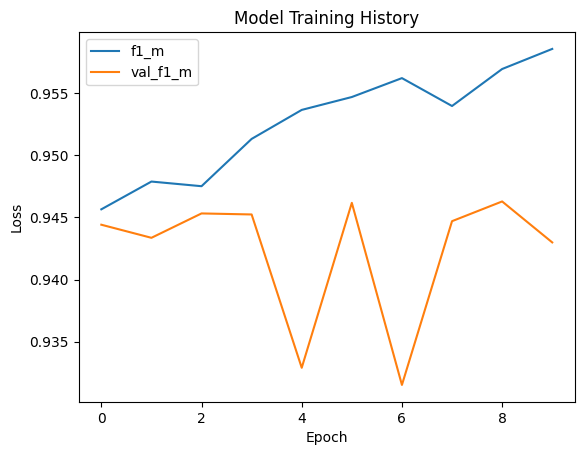

In [ ]:
plt.plot(history.history['f1_m'], label='f1_m')
plt.plot(history.history['val_f1_m'], label='val_f1_m')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training History')
plt.legend()
plt.show()

In [ ]:
!mv /content/skoltech_unet_f1_9492.h5 {FOLDER + '/Weights'}

In [ ]:
from sklearn.metrics import f1_score
import math

In [ ]:
def index2color(index):
    return [0, 0, 0] if np.argmax(index) == 0 else [255, 0, 0]

In [ ]:
def predict(image):
    np_img = keras.utils.img_to_array(image)
    np_img = np_img.reshape(1, *IMG_SIZE, 3)
    mask = np.array(model(np_img)[0]).reshape(-1, 2)
    mask = np.array([index2color(i) for i in mask])
    mask = mask.reshape(*IMG_SIZE, 3).astype('uint8')
    mask = Image.fromarray(mask).convert('RGB')
    return mask

In [ ]:
def segmentate_test(i):
    x_img = Image.fromarray(x_test[i]).convert('RGB')
    y_img = Image.fromarray(y_test[i]).convert('RGB')
    mask = predict(image)

    f1 = f1_m(np.array(mask).astype('uint8'), np.array(y_img).astype('uint8'))
    print('F1 Score:', f1)
    print()

    ig, axs = plt.subplots(1, 3, figsize=(8, 4))
    axs[0].imshow(x_img)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Predict')
    axs[2].imshow(y_img)
    axs[2].set_title('Answer')
    plt.show()
    print()

In [ ]:
from PIL import Image
from sklearn.metrics import f1_score

img1 = Image.open('/content/predict.png')
img2 = Image.open('/content/answer.png')

img1_array = np.array(img1).reshape(-1)
img2_array = np.array(img2)

# Ensure the images have the same size
if img1_array.shape != img2_array.shape:
    raise ValueError("Images must have the same size")

# Replace 'true_labels' and 'predicted_labels' with the appropriate arrays
precision, recall, _ = f1_score(y_pred=img1_array, y_true=img2_array)

f1_score = 2 * (precision * recall) / (precision + recall)

print(f1_score)

ValueError: ignored

In [ ]:
for i in range(0, 10):
    segmentate_test(i)

InvalidArgumentError: ignored